In [1]:

import torch.utils.data




In [35]:
nz = 124
ngf = 64
ndf = 64
image_size = 64
workers = 2
nc = 3
ngpu=1
batch_size = 32
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
number_epochs = 500
device = 'cpu'
lr = 0.0002
beta = 0.5

In [36]:
dataset_path = 'E:\Programming\Python\Ai-Projects\CreaiveGAN\DATA'

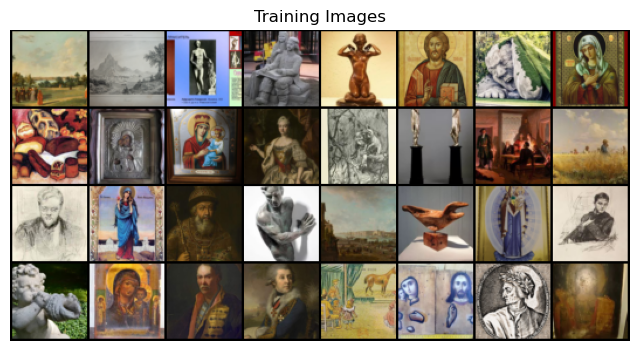

In [37]:
transform = transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.ImageFolder(
    root = dataset_path,
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset = dataset,shuffle=True,batch_size=batch_size
)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [38]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [39]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [40]:
 net_generator = Generator(ngpu).to(device)

# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

net_generator.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(124, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [42]:
net_discriminator = Discriminator(ngpu).to(device)


net_discriminator.apply(weights_init)

print(net_discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [43]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
beta1 = 0.5
# Setup Adam optimizers for both G and D
discriminator_optim = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
generator_optim = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [44]:

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(number_epochs):
    for i, data in enumerate(dataloader, 0):


        net_discriminator.zero_grad()

        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)

        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = net_discriminator(real_cpu).view(-1)

        error_discriminator_real = criterion(output, label)

        error_discriminator_real.backward()
        D_x = output.mean().item()


        noise = torch.randn(b_size, z_dim, 1, 1, device=device)

        fake = net_generator(noise)
        label.fill_(fake_label)

        output = net_discriminator(fake.detach()).view(-1)

        error_discriminator_fake = criterion(output, label)

        error_discriminator_fake.backward()
        D_G_z1 = output.mean().item()

        error_discriminator = error_discriminator_real + error_discriminator_fake

        discriminator_optim.step()


        net_generator.zero_grad()
        label.fill_(real_label)

        output = net_discriminator(fake).view(-1)

        error_generator = criterion(output, label)

        error_generator.backward()
        D_G_z2 = output.mean().item()

        generator_optim.step()


        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

        print(f'\033[1;36m\r Epoch : [{epoch}/{number_epochs}] | batchNumber : [{i}] | EGenerator : {error_generator.item()} | DGenerator : {error_discriminator.item()}',end='')

        if (iters % 500 == 0) or ((epoch == number_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    print()

Starting Training Loop...
 Epoch : [0/500] | batchNumber : [32] | EGenerator : 0.9244592189788818 | DGenerator : 1.5104961395263672

E:\Conda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 Epoch : [0/500] | batchNumber : [258] | EGenerator : 0.7147608399391174 | DGenerator : 1.71574008464813231;36m
 Epoch : [1/500] | batchNumber : [258] | EGenerator : 0.9422345757484436 | DGenerator : 1.89227616786956791;36m
 Epoch : [2/500] | batchNumber : [258] | EGenerator : 1.1496241092681885 | DGenerator : 1.44990158081054691;36m
 Epoch : [3/500] | batchNumber : [258] | EGenerator : 0.7860533595085144 | DGenerator : 1.9657124280929565;36m
 Epoch : [4/500] | batchNumber : [258] | EGenerator : 0.9622397422790527 | DGenerator : 1.53672003746032711;36m
 Epoch : [5/500] | batchNumber : [258] | EGenerator : 0.8241740465164185 | DGenerator : 1.86452746391296391;36m
 Epoch : [6/500] | batchNumber : [258] | EGenerator : 0.7378814220428467 | DGenerator : 1.601453065872192436m
 Epoch : [7/500] | batchNumber : [189] | EGenerator : 0.9527526497840881 | DGenerator : 1.6799416542053223;36m

KeyboardInterrupt: 

In [31]:
img_list

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5042,  ..., 0.5324, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.5304,  ..., 0.5183, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4819,  ..., 0.4871, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4861,  ..., 0.5043, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.5489,  ...,

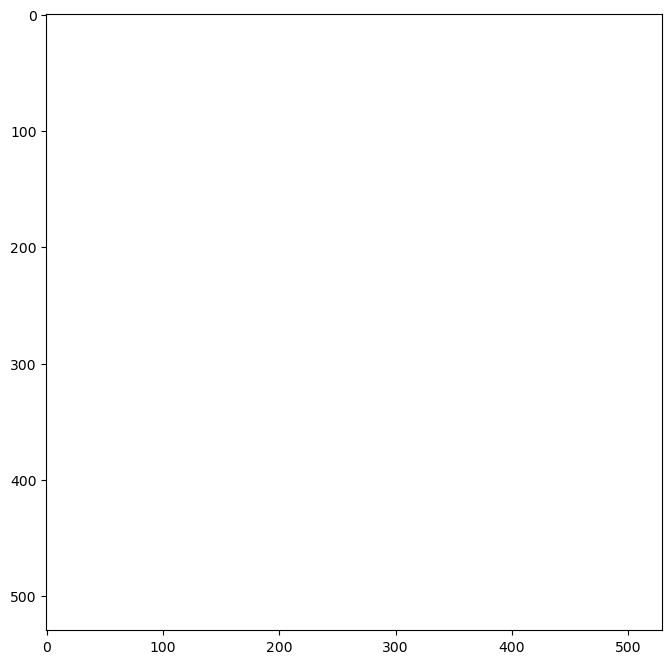

In [45]:
fig = plt.figure(figsize=(8,8))
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[:64]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

In [46]:

HTML(ani.to_jshtml())